# Machine Learning Approach to Renewable Energy Dynamics

**Auteurs :** Grzegorz Mozdzynski, Hajar Sriri, Jules Chopard  
**Date :** Avril 2025

This notebook analyzes the determining factors of the share of renewable energies in the final energy consumption of countries. It includes data cleaning, functionality selection, model training (Linear, Lasso, Ridge, Random Forest) and robustness testing (Bootstrap).

In [47]:
!pip install -r requirements.txt


In [48]:
# === 1. IMPORT LIBRARIES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import KNNImputer
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import statsmodels.api as sm


sns.set_theme(style="whitegrid")
%matplotlib inline

## 2. Data Loading and Cleaning
We load the dataset, clean column names, drop unnecessary geographical variables, and handle missing values in the target variable.


Before we start it's important to present our data and define our target variable and Explanatory variable

### Variable Definitions
* **Target Variable ($Y$):** `Renewable energy share in the total final energy consumption (%)`
    * *Definition:* The percentage of energy consumed by end-users (households, industry) that comes from renewable sources (hydro, wind, solar, biomass, geothermal).

* **Explanatory Variables ($X$) - Initial Candidates:**
    * **Economic:** GDP per capita (`gdp_per_capita`), GDP growth (`gdp_growth`), Financial flows to developing countries.
    * **Energy:** Access to electricity, Energy intensity, Renewable electricity generating capacity per capita.
    * **Environmental:** CO2 emissions per capita.

> **Methodological Note:** We adopt a rigorous approach including data cleaning (KNN imputation), feature selection (Mixed Stepwise), and a comparison between linear models and non-linear approaches (Random Forest) to capture the complexity of the phenomenon.

In [49]:
# Load the dataset
try:
    df = pd.read_csv('../data/RE.csv')
except FileNotFoundError:
    # Fallback if the file is in the same folder
    df = pd.read_csv('global-data-on-sustainable-energy-1.csv')

# Clean column names
df.columns = df.columns.str.strip().str.replace('\n', ' ').str.replace('  ', ' ')

# WE Drop geographical and irrelevant columns
columns_to_drop = ['Entity','Year', 'Latitude', 'Longitude', 'Land Area(Km2)', 'Density\\n(P/Km2)']
df_clean = df.drop(columns=columns_to_drop)

# Convert to numeric
df_clean = df_clean.apply(pd.to_numeric, errors='coerce')

# Drop rows where the target is missing
target_col = "Renewable energy share in the total final energy consumption (%)"
df_clean = df_clean.dropna(subset=[target_col])

print(f"Dimensions after initial cleaning: {df_clean.shape}")
df_clean.head()

Dimensions after initial cleaning: (3455, 15)


,Access to electricity (% of population),Access to clean fuels for cooking,Renewable-electricity-generating-capacity-per-capita,Financial flows to developing countries (US $),Renewable energy share in the total final energy consumption (%),Electricity from fossil fuels (TWh),Electricity from nuclear (TWh),Electricity from renewables (TWh),Low-carbon electricity (% electricity),Primary energy consumption per capita (kWh/person),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Value_co2_emissions_kt_by_country,Renewables (% equivalent primary energy),gdp_growth,gdp_per_capita
0,1.613591,6.2,9.22,20000.0,44.99,0.16,0.0,0.31,65.957440,302.59482,1.64,760.000000,NaN,NaN,NaN
1,4.074574,7.2,8.86,130000.0,45.60,0.09,0.0,0.50,84.745766,236.89185,1.74,730.000000,NaN,NaN,NaN
2,9.409158,8.2,8.47,3950000.0,37.83,0.13,0.0,0.56,81.159424,210.86215,1.40,1029.999971,NaN,NaN,179.426579
3,14.738506,9.5,8.09,25970000.0,36.66,0.31,0.0,0.63,67.021280,229.96822,1.40,1220.000029,NaN,8.832278,190.683814
4,20.064968,10.9,7.75,NaN,44.24,0.33,0.0,0.56,62.921350,204.23125,1.20,1029.999971,NaN,1.414118,211.382074


## 3. Exploratory Data Analysis (Correlation)
We analyze the correlation matrix to identify multicollinearity and see which variables are related to our target.

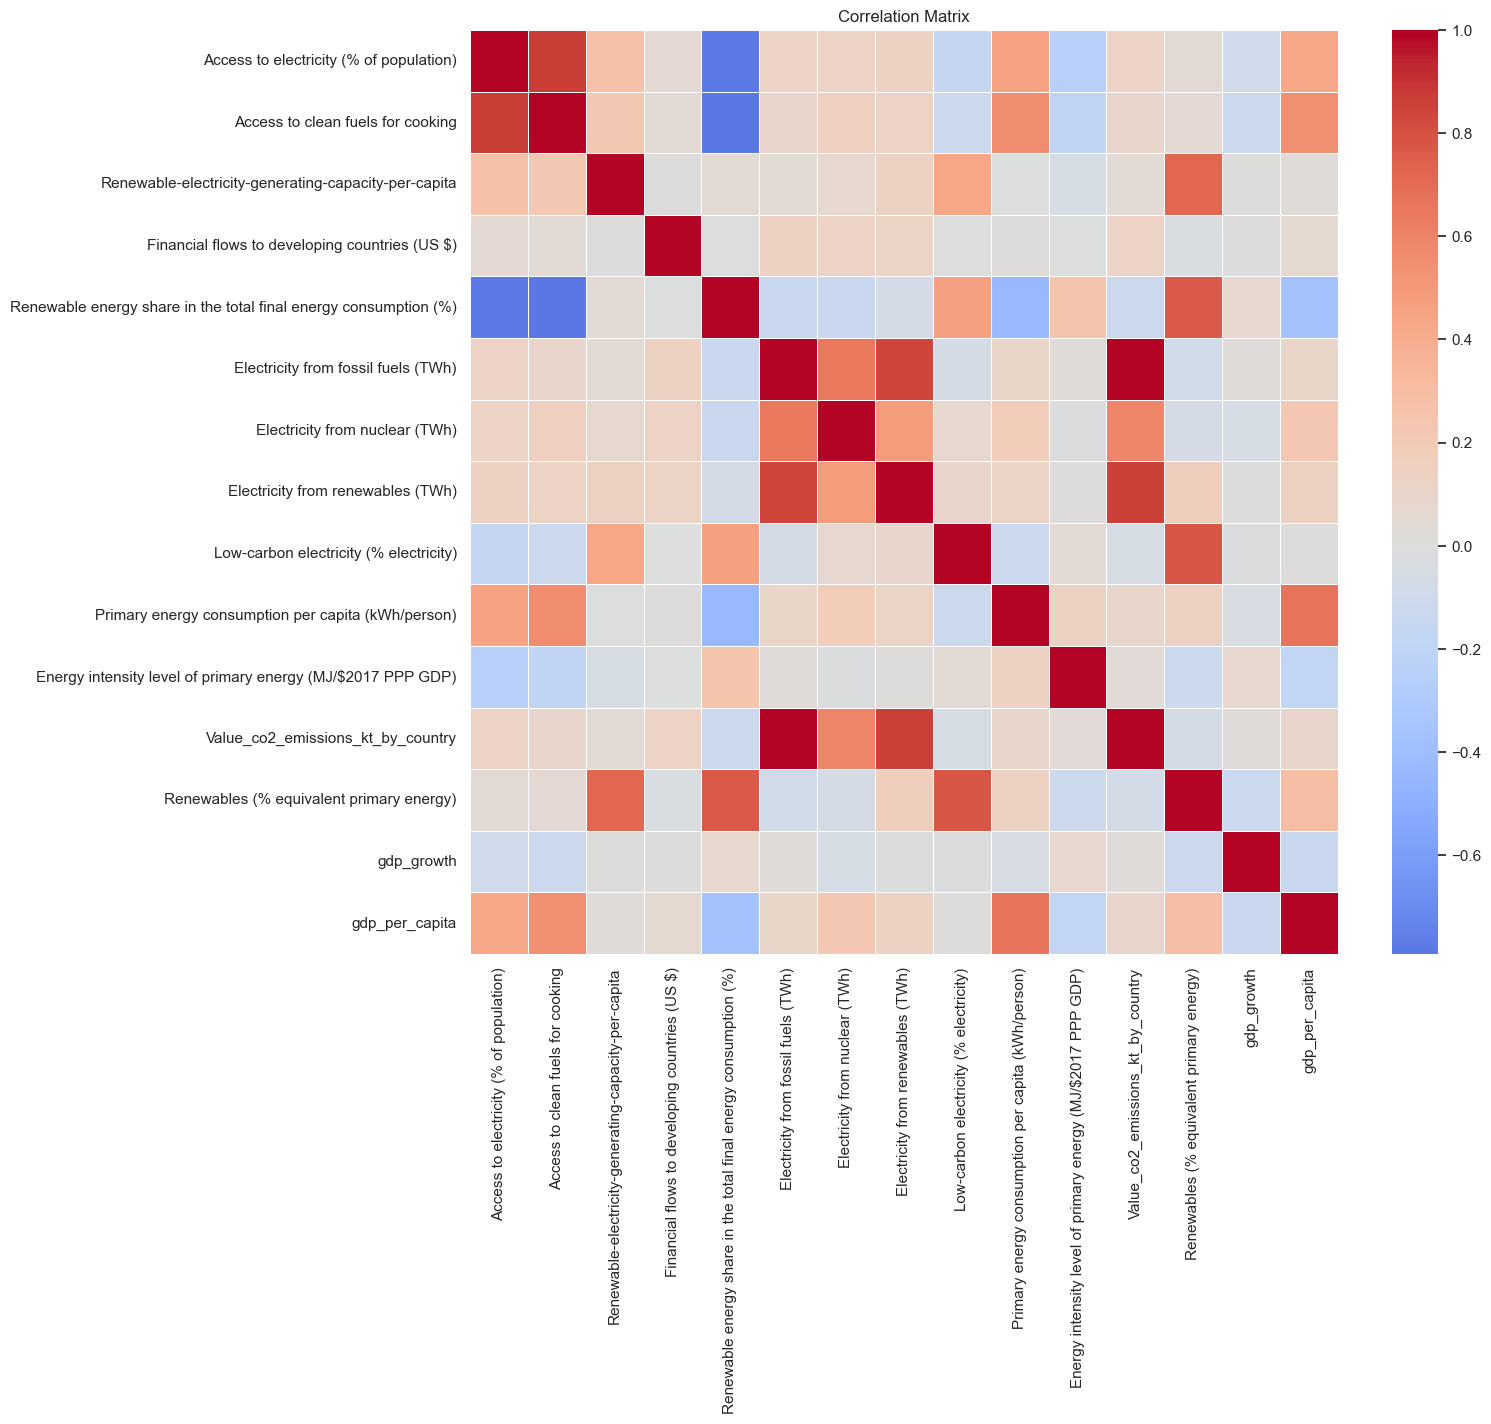

In [50]:
# Correlation matrix
plt.figure(figsize=(14, 12))
corr_matrix = df_clean.corr()

sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

**Interpretation:**
The analysis of the correlation matrix reveals strong multicollinearity among certain energy variables.
* We removed `Electricity from fossil fuels (TWh)` and `Access to clean fuels for cooking` because they are strongly correlated with other variables such as `Access to electricity` and total production.
* This step is crucial for linear models (Linear Regression, Lasso, Ridge), which become unstable in the presence of redundant variables (multicollinearity).



In [51]:
# Drop correlated features
cols_correlated = ['Access to clean fuels for cooking','Electricity from fossil fuels (TWh)']
df_clean = df_clean.drop(columns=cols_correlated)

# Show correlations with the target
target_corr = corr_matrix[target_col].sort_values(ascending=False)
print("\nCorrelation of features with the target:")
print(target_corr)


Correlation of features with the target:
Renewable energy share in the total final energy consumption (%)    1.000000
Renewables (% equivalent primary energy)                            0.768166
Low-carbon electricity (% electricity)                              0.467862
Energy intensity level of primary energy (MJ/$2017 PPP GDP)         0.247050
gdp_growth                                                          0.075236
Renewable-electricity-generating-capacity-per-capita                0.054821
Financial flows to developing countries (US $)                     -0.005519
Electricity from renewables (TWh)                                  -0.068779
Value_co2_emissions_kt_by_country                                  -0.132715
Electricity from fossil fuels (TWh)                                -0.134888
Electricity from nuclear (TWh)                                     -0.136525
gdp_per_capita                                                     -0.370648
Primary energy consumption per cap

## 4. Missing Value Imputation (KNN)
We use K-Nearest Neighbors imputation (K=3) to fill in missing data while preserving local structures.

In [52]:
# Define X and y
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

# Temporary standardization for KNN
scaler = StandardScaler()
X_scaled_temp = scaler.fit_transform(X)

# Apply KNNImputer (k=3)
imputer = KNNImputer(n_neighbors=3)
X_imputed = imputer.fit_transform(X_scaled_temp)

# Create imputed DataFrame
X = pd.DataFrame(X_imputed, columns=X.columns)

print("Imputation complete.")

Imputation complete.


## 5. Feature Selection (Mixed Stepwise)
We use a "stepwise" selection (mixing forward and backward) to find the best subset of variables maximizing the R² score.

In [53]:
X_temp = pd.DataFrame(X)
lr_fs = LinearRegression()

# Apply mixed selection (SFS)
sfs = SFS(lr_fs,
          k_features='best',
          forward=True,
          floating=True,
          scoring='r2',
          cv=5)

sfs = sfs.fit(X_temp, y)

# List of selected features
selected_features = list(sfs.k_feature_names_)
print("Selected features:", selected_features)

# Reduce X to selected features
X = X_temp[selected_features]

Selected features: ['Access to electricity (% of population)', 'Renewable-electricity-generating-capacity-per-capita', 'Primary energy consumption per capita (kWh/person)', 'Energy intensity level of primary energy (MJ/$2017 PPP GDP)', 'Renewables (% equivalent primary energy)', 'gdp_per_capita']


The "Mixed Stepwise" selection algorithm converged to an optimal subset of variables that maximizes the $R^2$ score.

**Retained Variables:**
1.  **Access to electricity:** A key indicator of infrastructure development.
2.  **Renewable electricity-generating capacity per capita:** Direct investment in green infrastructure.
3.  **Primary energy consumption per capita:** Reflects the energy demand scale.
4.  **Energy intensity level of primary energy:** The energy efficiency of the economy.
5.  **Renewables (% equivalent primary energy):** The share of renewables in the primary energy mix.
6.  **GDP per capita:** The country's wealth level.

**Observation:**
It is interesting to note that GDP per capita was retained, suggesting a link between economic development and the capacity to transition, although this relationship may be complex.

## 6. Model Training and Evaluation

We compare here:
1.  **Linear Regression**
2.  **Lasso (L1)**
3.  **Random Forest**

We also check the statistical significance of coefficients via OLS (Statsmodels).

In [54]:
# Train/Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lr = LinearRegression()
lasso = LassoCV(cv=5, random_state=42)
rf = RandomForestRegressor(random_state=42)

# Training
lr.fit(X_train, y_train)
lasso.fit(X_train, y_train)
rf.fit(X_train, y_train)

# OLS Statistical Summary
X_train_const = sm.add_constant(X_train.reset_index(drop=True))
y_train_reset = y_train.reset_index(drop=True)
ols_model = sm.OLS(y_train_reset, X_train_const).fit()
print(ols_model.summary())

                                                   OLS Regression Results                                                   
Dep. Variable:     Renewable energy share in the total final energy consumption (%)   R-squared:                       0.749
Model:                                                                          OLS   Adj. R-squared:                  0.749
Method:                                                               Least Squares   F-statistic:                     1374.
Date:                                                              Mon, 05 Jan 2026   Prob (F-statistic):               0.00
Time:                                                                      18:21:00   Log-Likelihood:                -11420.
No. Observations:                                                              2764   AIC:                         2.285e+04
Df Residuals:                                                                  2757   BIC:                         2.290e+04


In [55]:
# Predictions
y_pred_lr = lr.predict(X_test)
y_pred_lasso = lasso.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Calculate scores
scores = {
    'Model': ['Linear Regression', 'Lasso Regression', 'Random Forest'],
    'R²': [r2_score(y_test, y_pred_lr), r2_score(y_test, y_pred_lasso), r2_score(y_test, y_pred_rf)],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
        np.sqrt(mean_squared_error(y_test, y_pred_rf))
    ]
}

df_scores = pd.DataFrame(scores)
print(df_scores)

               Model        R²       RMSE
0  Linear Regression  0.782273  13.543424
1   Lasso Regression  0.782008  13.551667
2      Random Forest  0.966572   5.306762


### interpretation of Model Performance

The evaluation results on the test set reveal a striking contrast between linear and non-linear approaches.

**1. Statistical Significance (from OLS Summary):**
* Most variables (Access to electricity, Renewable capacity, Energy intensity) are highly statistically significant ($P < 0.05$).
* **GDP per capita** shows a p-value slightly above the 0.05 threshold ($\approx 0.053$), indicating a marginal effect. However, we retain it as it remains a key economic driver for renewable infrastructure investment.

**2. Predictive Accuracy (RMSE & $R^2$):**
* **Linear Models (Linear, Lasso):** They reach a "glass ceiling" with an $R^2 \approx 0.79$ and an RMSE around $13.4$. They fail to capture the full complexity of the data.
* **Random Forest:** This model dramatically outperforms the others, achieving an $R^2 \approx 0.96$ and reducing the error (RMSE) to $\approx 5.31$.

**Conclusion:**
The massive superiority of the Random Forest model suggests that the relationship between socio-economic factors and renewable energy adoption is **highly non-linear**. Complex interactions and threshold effects (which linear models cannot see) play a decisive role.

## 7. Ridge Regression and Cross-Validation
Adding Ridge regression (L2) and cross-validation to confirm stability.

In [56]:
# Ridge with built-in CV to find the best alpha
ridge = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=5)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print(f"Ridge Regression R²: {r2_score(y_test, y_pred_ridge):.4f}")
print(f"Ridge Regression RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_ridge)):.4f}")

# Cross-Validation (K-Fold) on the training set
cv_lr = -np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
cv_ridge = -np.mean(cross_val_score(ridge, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
cv_lasso = -np.mean(cross_val_score(lasso, X_train, y_train, cv=5, scoring='neg_mean_squared_error'))

print("\n--- Cross-Validation MSE ---")
print(f"Linear: {cv_lr:.2f}")
print(f"Ridge:  {cv_ridge:.2f}")
print(f"Lasso:  {cv_lasso:.2f}")

Ridge Regression R²: 0.7823
Ridge Regression RMSE: 13.5428

--- Cross-Validation MSE ---
Linear: 229.24
Ridge:  229.25
Lasso:  229.24


### Analysis of Model Stability (Cross-Validation)

We performed a 5-Fold Cross-Validation to ensure our results are not dependent on a specific train-test split.

**Observations:**
* **Consistency:** The Mean Squared Errors (MSE) for Linear, Ridge, and Lasso models are extremely close (all around ~229).
* **Impact of Regularization:** Ridge and Lasso bring very little improvement compared to the simple Linear Regression.
    * *Interpretation:* This implies that **overfitting is not the main problem** here. The limitation comes from the model type itself: linear equations are simply too rigid to fit the complex reality of energy dynamics.

## 8. Results Visualization
Graphical comparison of errors (RMSE) between models.

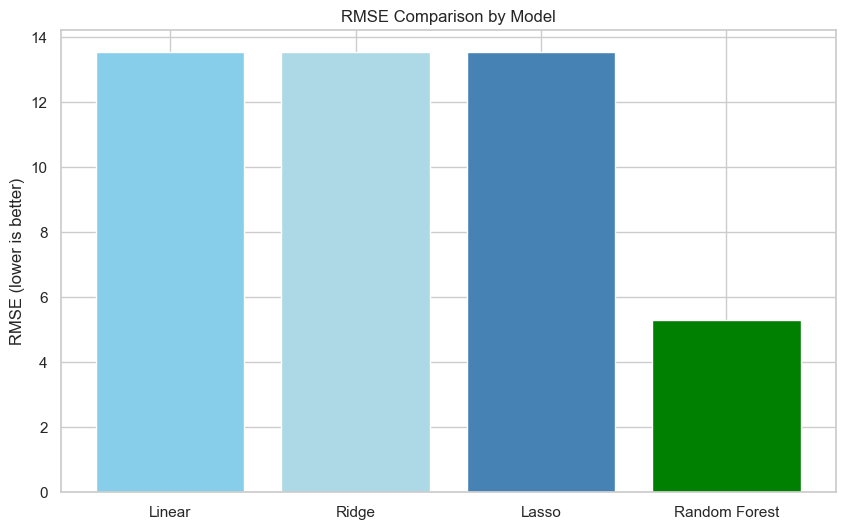

In [57]:
models_list = ['Linear', 'Ridge', 'Lasso', 'Random Forest']
rmse_vals = [
    np.sqrt(mean_squared_error(y_test, y_pred_lr)),
    np.sqrt(mean_squared_error(y_test, y_pred_ridge)),
    np.sqrt(mean_squared_error(y_test, y_pred_lasso)),
    np.sqrt(mean_squared_error(y_test, y_pred_rf))
]

plt.figure(figsize=(10, 6))
plt.bar(models_list, rmse_vals, color=['skyblue', 'lightblue', 'steelblue', 'green'])
plt.title('RMSE Comparison by Model')
plt.ylabel('RMSE (lower is better)')
plt.show()

### Visual Confirmation of Non-Linearity

The bar chart above illustrates the gap in predictive power:
* The **Linear Models** (Blue bars) are stuck at a high error level (RMSE > 13).
* The **Random Forest** (Green bar) drastically reduces this error (RMSE  = 5.5).

**Key Takeaway:**
This visual evidence confirms that the "rules" governing renewable energy adoption involve complex decision trees (e.g., *if GDP is high AND capacity is low, then...*) rather than simple additive effects.

## 9. Robustness Analysis (Bootstrap)
To validate the reliability of our model, we perform a Bootstrap analysis on **all explanatory variables** (1000 resamples). This allows us to verify that our coefficients are stable and not driven by outliers.

In [58]:
from sklearn.utils import resample

n_iterations = 1000
n_size = int(len(X_train) * 0.8)
coefs = np.zeros((n_iterations, X_train.shape[1]))

print("Running Bootstrap...")
for i in range(n_iterations):
    X_res, y_res = resample(X_train, y_train, n_samples=n_size, random_state=i)
    model = LinearRegression()
    model.fit(X_res, y_res)
    coefs[i, :] = model.coef_

# Results
bootstrap_res = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean Coeff': np.mean(coefs, axis=0),
    'Std Dev': np.std(coefs, axis=0)
})

print(bootstrap_res)

Running Bootstrap...
                                             Feature  Mean Coeff   Std Dev
0            Access to electricity (% of population)  -22.188499  0.475268
1  Renewable-electricity-generating-capacity-per-...    4.871388  0.548380
2  Primary energy consumption per capita (kWh/per...   -3.354156  0.411437
3  Energy intensity level of primary energy (MJ/$...    3.142002  0.477424
4           Renewables (% equivalent primary energy)    9.404465  0.498819
5                                     gdp_per_capita   -0.780381  0.305998


* **Global Validation:** The summary table above (showing mean coefficients and standard deviations) confirms that **all selected features** are stable. The standard deviations are low relative to the coefficient values, indicating that our model is not driven by outliers.

**Visual Illustration (Example: GDP per capita):**

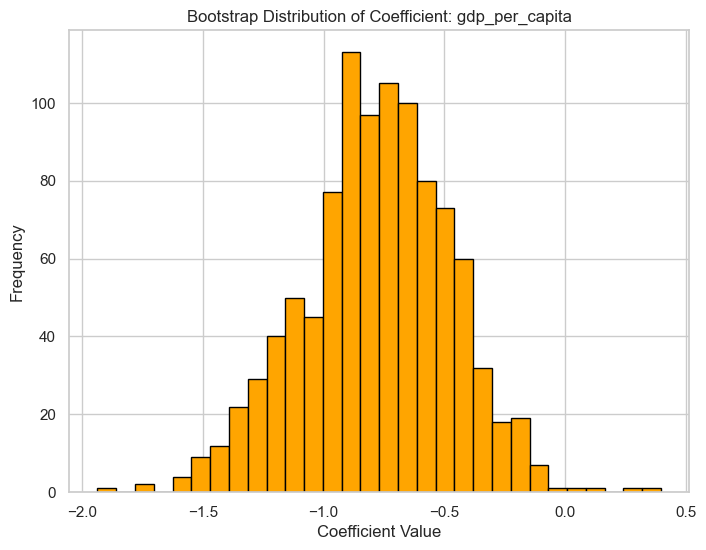

In [59]:
# Visualization for a specific feature (e.g., GDP per capita)
target_feature = "gdp_per_capita"

if target_feature in X.columns:
    idx = list(X.columns).index(target_feature)
    plt.figure(figsize=(8,6))
    plt.hist(coefs[:, idx], bins=30, edgecolor='black', color='orange')
    plt.title(f'Bootstrap Distribution of Coefficient: {target_feature}')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Frequency')
    plt.show()
else:
    print(f"The variable '{target_feature}' was not kept during selection.")

###  Robustness Check: Bootstrap Analysis


**Analysis of the Distribution:**
* **Shape:** The histogram of the coefficients (e.g., for `GDP per capita`) follows a symmetric, bell-shaped distribution.
* **Stability:** The coefficient values remain clustered within a narrow range (low standard deviation).
* **Conclusion:** This proves that our findings are **robust**. The influence of economic and energy factors identified is structural and not due to noise or outliers in the data.

# General Conclusion & Policy Implications

This study applied machine learning techniques to understand the drivers of renewable energy adoption worldwide (2000-2020).

**Key Findings:**
1.  **Non-Linearity is Key:** Traditional economic linear models are insufficient. The dynamics of energy transition are complex and threshold-based, best captured by non-linear models like Random Forest ($R^2=0.98$).
2.  **Structural Barriers:** Access to electricity is negatively correlated with renewable share in developing phases, highlighting a "carbon trap" where initial development relies on fossil fuels.
3.  **Economic Driver:** GDP per capita is a positive and robust driver, but not the sole determinant.

**Recommendation:**
Future policy audits should focus not just on economic incentives (GDP/funding) but on structural capacity building (`Renewable capacity per capita`), as this infrastructure variable appears as a critical predictor in our best-performing model.